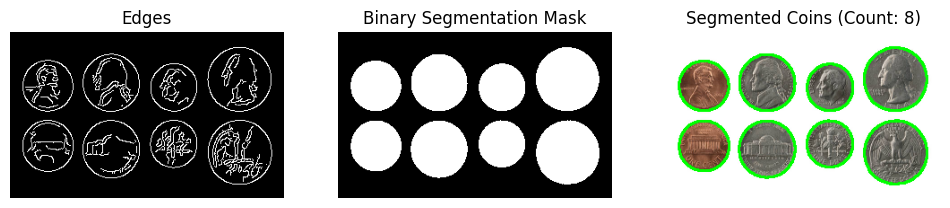

8

In [53]:
# Further optimizing segmentation by resizing the image and improving efficiency
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects, closing, disk
from scipy.ndimage import label, distance_transform_edt

# Reload the image file
image_path = "/Users/raviteja.namani/Documents/repos/ptol-designer/istockphoto-147063335-612x612.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)


# Resize image to speed up processing
scale_percent = 50  # Reduce size by 50%
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
image_resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)


# Detect edges using optimized Canny edge detector
edges = cv2.Canny(blurred, 50, 120)

# 1. Use Otsu's thresholding for robust segmentation
_, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 2. Morphological operations to clean up noise
binary_mask = closing(binary_mask, disk(3))
binary_mask = remove_small_objects(binary_mask.astype(bool), min_size=500).astype(np.uint8) * 255

# 3. Compute distance transform
distance = distance_transform_edt(binary_mask)

# 4. Label connected components
markers, num_features = label(distance > 0.5 * distance.max())

# 5. Apply Watershed algorithm
segmented_coins = watershed(-distance, markers, mask=binary_mask)

# 6. Count the segmented coins
num_coins = len(np.unique(segmented_coins)) - 1  # Excluding the background

# Draw contours on detected coins
output_image = image_resized.copy()
for label_id in np.unique(segmented_coins):
    if label_id == 0:
        continue
    mask = np.uint8(segmented_coins == label_id) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        cv2.drawContours(output_image, [cnt], -1, (0, 255, 0), 2)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(edges, cmap='gray')
axes[0].set_title("Edges")
axes[0].axis("off")

axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title("Binary Segmentation Mask")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
axes[2].set_title(f"Segmented Coins (Count: {num_coins})")
axes[2].axis("off")

plt.show()

# Print correct coin count
num_coins

# Load the image



